<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Fusion_2D_Wave_Equations_Using_PINNs_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Solving 2D Wave Equation
Training Neural Network to converge towards a well-defined solution of a PDE by way of minimising for the residuals across the spatio-temporal domain. Initial and Boundary conditions are met by introducing them into the loss function along with the PDE residuals.

Numerical Method - Spectral Solver using FFT. <br>
Code taken from [this tutorial.](http://people.bu.edu/andasari/courses/numericalpython/Week12Lecture21/Spectral_wave2.py) <br>

Equation:
```
u_tt = u_xx + u_yy on [-1,1] x [-1,1]
```

Dirichlet Boundary Conditions :
```
u=0
```

Initial Distribution :
```
 u(x,y,t=0) = exp(-40(x-4)^2 + y^2)
 ```

Initial Velocity Condition :
```
u_t(x,y,t=0) = 0
```


In [8]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import os
import sys
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import h5py
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [9]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Fusion')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Fusion/"
files_to_download = ["pde_2d_wave.h5"]

In [10]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Load conditions and the numerical solution

The numerical solution was computed by solving the Wave Equation using a spectral solver. The solution will not form the training data but will be used for comparing against the output of the neural network.

In [11]:
with h5py.File(join(data_path, 'Fusion/pde_2d_wave.h5'), 'r') as F:
    x = np.array(F['x'], dtype='float32')
    y = np.array(F['y'], dtype='float32')
    t = np.array(F['t'], dtype='float32')
    lb = np.array(F['lower_range'], dtype='float32')   # Lower Bounds of the domain
    ub = np.array(F['upper_range'], dtype='float32')   # Upper Bounds of the domain
    u_sol = np.array(F['U_sol'], dtype='float32')      # Solution of the 2D Wave Equation
    X_i = np.array(F['X_i'], dtype='float32')          # Data for Initial Input
    U_i = np.array(F['u_i'], dtype='float32')          # Data for Initial Input
    X_b = np.array(F['X_b'], dtype='float32')          # Data for Boundary Input
    X_f = np.array(F['X_f'], dtype='float32')          # Data for Domain Input



---

# 2. Build the network

We will build a neural network with 5 hidden layers.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
in_features = 3
num_layers = 5
out_features = 1
num_neurons = 100


npde_net = Sequential()
npde_net.add(Dense(100, activation='tanh', input_shape=(in_features,)))
for _ in range(num_layers - 1):
     npde_net.add(Dense(num_neurons, activation='tanh'))

npde_net.add(Dense(out_features))
```
    
</p>
</details>

In [16]:
in_features = 3
num_layers = 5
out_features = 1
num_neurons = 100


npde_net = Sequential()
npde_net.add(keras.Input(shape=(in_features,)))
npde_net.add(Dense(100, activation='tanh'))
for _ in range(num_layers - 1):
     npde_net.add(Dense(num_neurons, activation='tanh'))

npde_net.add(Dense(out_features))

In [17]:
optimizer = tf.keras.optimizers.Adam()

def train_step(X_i, Y_i, X_b, X_f):
    with tf.GradientTape() as tape:
        # recon loss
        recon_loss = npde_net(X_i) - Y_i

        # initial_cond_loss
        xi_ = tf.Variable(X_i[:, 0:1])
        yi_ = tf.Variable(X_i[:, 1:2])
        ti_ = tf.Variable(X_i[:, 2:3])
        with tf.GradientTape() as ti:
            ui = npde_net(tf.concat([xi_,yi_,ti_],1))

        ui_t = ti.gradient(ui, ti_)
        initial_cond_loss = ui_t - 0

        # boundary_loss
        ub = npde_net(X_b)
        bc_loss = ub - 0

        # domain_loss
        xf_ = tf.Variable(X_f[:, 0:1])
        yf_ = tf.Variable(X_f[:, 1:2])
        tf_ = tf.Variable(X_f[:, 2:3])

        # build graph with GradientTape
        with tf.GradientTape() as tapex, tf.GradientTape() as tapey, tf.GradientTape() as tapet:
            with tf.GradientTape() as tape1:
                uf = npde_net(tf.concat([xf_,yf_,tf_],1))

            deriv1 = tape1.gradient(uf, {'x': xf_, 'y': yf_, 't':tf_})
        uf_xx = tapex.gradient(deriv1['x'], xf_)
        uf_yy = tapey.gradient(deriv1['y'], yf_)
        uf_tt = tapet.gradient(deriv1['t'], tf_)

        pde_loss = uf_tt - (uf_xx + uf_yy)

        initial_loss = tf.reduce_mean(tf.math.square(recon_loss)) + tf.reduce_mean(tf.math.square(initial_cond_loss))
        boundary_loss = tf.reduce_mean(tf.math.square(bc_loss))
        domain_loss = tf.reduce_mean(tf.math.square(pde_loss))

        loss = initial_loss + boundary_loss + domain_loss

    grads = tape.gradient(loss, npde_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, npde_net.trainable_variables))
    return loss

In [18]:
interations = 5000
for i in range(interations):
    loss = train_step(X_i, U_i, X_b, X_f)
    if i % 100 == 0:
        print('epoch {}/{} ({:.2f}%): loss: {}'.format(i,interations, 100*(i/interations), loss.numpy()))
print('Final loss: {}'.format(loss.numpy()))

epoch 0/5000 (0.00%): loss: 0.15849293768405914
epoch 100/5000 (2.00%): loss: 0.00952221266925335
epoch 200/5000 (4.00%): loss: 0.00940338708460331
epoch 300/5000 (6.00%): loss: 0.00930080097168684
epoch 400/5000 (8.00%): loss: 0.009205657988786697
epoch 500/5000 (10.00%): loss: 0.009036248549818993
epoch 600/5000 (12.00%): loss: 0.00887676328420639
epoch 700/5000 (14.00%): loss: 0.009157564491033554
epoch 800/5000 (16.00%): loss: 0.00874470453709364
epoch 900/5000 (18.00%): loss: 0.008595096878707409
epoch 1000/5000 (20.00%): loss: 0.008438870310783386
epoch 1100/5000 (22.00%): loss: 0.008525705896317959
epoch 1200/5000 (24.00%): loss: 0.008242166601121426
epoch 1300/5000 (26.00%): loss: 0.008021996356546879
epoch 1400/5000 (28.00%): loss: 0.008309924043715
epoch 1500/5000 (30.00%): loss: 0.009561901912093163
epoch 1600/5000 (32.00%): loss: 0.007044419180601835
epoch 1700/5000 (34.00%): loss: 0.006810119841247797
epoch 1800/5000 (36.00%): loss: 0.005978790577501059
epoch 1900/5000 (38

---

# 3. Analyse results

### Predict u from pairs of x, y, and t

In [19]:
X, Y = np.meshgrid(x, y)
XY_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
T_star = np.expand_dims(np.repeat(t, len(XY_star)), 1)
X_star_tiled = np.tile(XY_star, (len(t), 1))

X_star = np.hstack((X_star_tiled, T_star))
u_pred = npde_net(X_star).numpy()
u_pred = u_pred.reshape(u_sol.shape)

### Compare solution by the neural network against the Numerical solution.

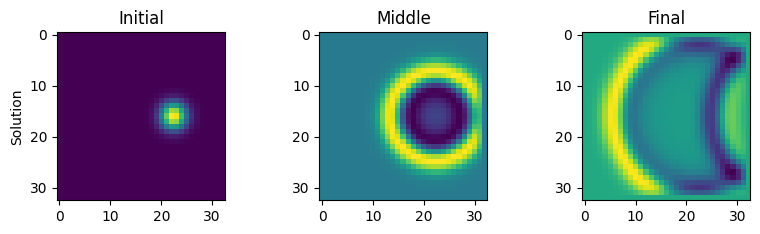

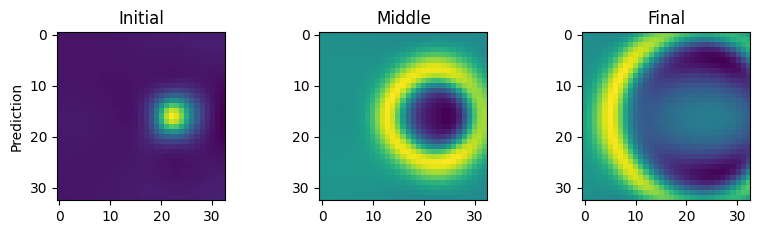

In [20]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2,3,1)
ax.imshow(u_sol[0])
ax.title.set_text('Initial')
ax.set_ylabel('Solution')

ax = fig.add_subplot(2,3,2)
ax.imshow(u_sol[int(len(u_sol)/2)])
ax.title.set_text('Middle')

ax = fig.add_subplot(2,3,3)
ax.imshow(u_sol[-1])
ax.title.set_text('Final')


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2,3,1)
ax.imshow(u_pred[0])
ax.title.set_text('Initial')
ax.set_ylabel('Prediction')

ax = fig.add_subplot(2,3,2)
ax.imshow(u_pred[int(len(u_sol)/2)])
ax.title.set_text('Middle')

ax = fig.add_subplot(2,3,3)
ax.imshow(u_pred[-1])
ax.title.set_text('Final')